In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import kagglehub
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [2]:
path = kagglehub.dataset_download("hearfool/vggface2")

100%|██████████| 2.32G/2.32G [00:19<00:00, 130MB/s]

Extracting files...


In [3]:
# path_to_train = r"C://Users//HOME//Desktop//train"
# path_to_val = r"C://Users//HOME//Desktop//val"
path_to_train = path + "//" + "train"
path_to_val = path + "//" + "val"

In [4]:
lengths = []

for sample_dir in tqdm(os.listdir(path_to_train)):
    lengths.append(os.listdir(path_to_train+"//"+sample_dir).__len__())

100%|██████████| 480/480 [00:00<00:00, 5719.96it/s]


In [5]:
lengths = []

for sample_dir in tqdm(os.listdir(path_to_val)):
    lengths.append(os.listdir(path_to_val+"//"+sample_dir).__len__())

100%|██████████| 60/60 [00:00<00:00, 5880.83it/s]


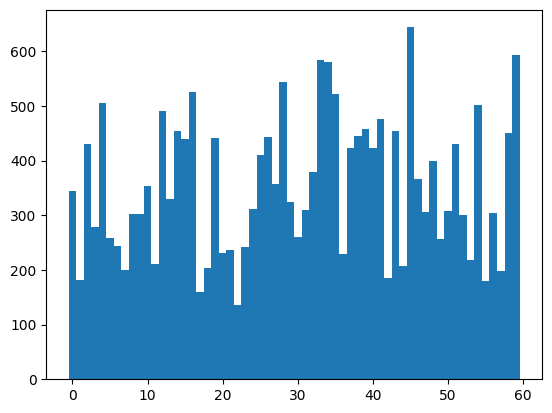

In [6]:
plt.bar(range(len(lengths)), lengths, width=1)
None

In [33]:
class VGG2(Dataset):

    def __init__(self, path, pic_num = 10, resize=(224,224)):
        self.path = path
        self.pic_num = pic_num
        self.resize = resize

    def __len__(self):
        return len(os.listdir(self.path))

    def __getitem__(self, idx):
        data = []

        sample_dir = random.choice(os.listdir(self.path))
        path = self.path+"//"+sample_dir
        choice = set(os.listdir(path))
        num = 0

        while num < self.pic_num:
            img_name = random.choice(list(choice))
            choice.remove(img_name)
            img_path = path + "//" + img_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB, cv2.CV_32FC3)

            if img.shape[0] < 224 or img.shape[1] < 224:
                continue
            num += 1

            img = cv2.resize(img, self.resize)
            rot_matrix = cv2.getRotationMatrix2D((self.resize[0]//2, self.resize[1]//2), np.random.normal(0,1,1)[0]*30,1)
            img_rotated = cv2.warpAffine(img, rot_matrix, self.resize).transpose(2,0,1)

            data.append(img_rotated)

        return np.array(data)

def collate_fn(batch):

    batch = torch.FloatTensor(np.array(batch))/255.0
    labels = [j for j in range(batch.shape[0]) for i in range(batch.shape[1])]

    return batch.flatten(end_dim=1), torch.ShortTensor(np.array(labels))

In [34]:
data_train = VGG2(path_to_train, pic_num=10)
train_loader = DataLoader(data_train, batch_size=120, collate_fn=collate_fn)

data_val = VGG2(path_to_val, pic_num=15)
val_loader = DataLoader(data_val, batch_size=60, collate_fn=collate_fn)

In [35]:
batch = train_loader.__iter__().__next__()

In [10]:
def triplets(data, target, net, mode="beginning", margin=0.4, n=3):

  embeddings = net(data)
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  except_list = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  except_list = dict()

  for i in num_list:

    if i in except_list and except_list[i] < n:
      except_list[i] += 1
    elif  i not in except_list: except_list[i] = 1
    else: continue

    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]

    if mode =="end_pos":
      positive_final = positive[torch.argmax(dist[i][positive])]
      negative_final = random.choice(negative)

    if mode == "end_neg":
      positive_final = random.choice(positive)
      negative_final = negative[torch.argmin(dist[i][negative])]

    if mode == "end":
      positive_final = positive[torch.argmax(dist[i][positive])]
      negative_final = negative[torch.argmin(dist[i][negative])]

    if mode == "beginning":
      positive_final = random.choice(positive)
      negative_final = random.choice(negative)

    if mode == "semi-hard":
      positive_final = positive[torch.argmax(dist[i][positive])]
      if ((dist[i][positive_final] <= dist[i][negative]) & (dist[i][negative] <= dist[i][positive_final] + margin)).sum() != 0:
        negative = negative[(dist[i][positive_final] <= dist[i][negative]) & (dist[i][negative] <= dist[i][positive_final] + margin)]
      negative_final = random.choice(negative)

    triplets.append((embeddings[i],embeddings[positive_final],embeddings[negative_final]))

  return triplets

In [36]:
class Face_net_v1(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.norm = nn.BatchNorm2d(3)
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), stride=(1,1),padding=(2,2)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(16))

    self.conv1a = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,1), stride=(1,1)),
                               nn.ReLU())

    self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(64))

    self.conv2a = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=(1,1)),
                               nn.ReLU())

    self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(64))
    self.conv3a = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=(1,1)),
                               nn.ReLU())

    self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(128))
    self.conv4a = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,1), stride=(1,1)),
                               nn.ReLU())

    self.conv5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(64))

    self.conv5a = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=(1,1)),
                               nn.ReLU())

    self.fc = nn.Sequential(nn.Linear(3136, 3136//2), nn.ReLU(), nn.Linear(3136//2, 3136//4), nn.ReLU(), nn.Linear(3136//4, 128))

  def forward(self, x):
    x = self.norm(x)
    x = self.conv1(x)
    x = self.conv1a(x)
    x = self.conv2(x)
    x = self.conv2a(x)
    x = self.conv3(x)
    x = self.conv3a(x)
    x = self.conv4(x)
    x = self.conv4a(x)
    x = self.conv5(x)
    x = self.conv5a(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return F.normalize(x)

In [37]:
model = Face_net_v1()
model(torch.zeros(1,3,224,224))

tensor([[ 0.0107,  0.1004,  0.1838, -0.1371, -0.2279, -0.1200,  0.0554, -0.0561,
          0.0839,  0.0053, -0.0037,  0.0126,  0.1352,  0.0735,  0.1355, -0.0369,
         -0.1380,  0.0353,  0.0094, -0.0699, -0.0871,  0.0593, -0.0142,  0.0046,
         -0.1192, -0.0175, -0.0458,  0.0131,  0.1275, -0.0058,  0.0057,  0.0232,
         -0.0505,  0.0190, -0.0087, -0.0170,  0.0268,  0.1775,  0.0067, -0.0811,
         -0.0144,  0.0339,  0.1014,  0.1251,  0.0999,  0.0258,  0.0262, -0.0358,
         -0.0866,  0.1117,  0.1010,  0.0265,  0.1076, -0.0590, -0.0816,  0.0923,
         -0.0742, -0.0088,  0.0251, -0.1685, -0.1050,  0.0635, -0.0302, -0.0084,
         -0.0803,  0.0067, -0.0725, -0.0815,  0.0715,  0.0071,  0.0547, -0.0546,
         -0.0304, -0.0220,  0.1671,  0.0048,  0.1421,  0.0219,  0.1294, -0.1291,
         -0.0774,  0.0764,  0.1617,  0.1930, -0.0295,  0.0574,  0.2005,  0.0866,
          0.0249,  0.1357, -0.0308,  0.1832,  0.0645,  0.1320, -0.0177,  0.0828,
          0.1199, -0.1192, -

In [38]:
device = "cuda"
model = Face_net_v1().to(device)
# model.load_state_dict(torch.load("model_0.69_224x224_128"))
optimizer = Adam(model.parameters(), lr=1e-3)
margin = 0.4
loss = nn.TripletMarginLoss(margin)

In [39]:
def accuracy(data, target, net):
  embeddings = net(data)
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  distances_slice = []
  answers = []
  except_list = []
  for i in num_list:
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    positive_final = random.choice(positive)
    negative_final = random.choice(negative)
    distances_slice.append(dist[i][positive_final].item())
    distances_slice.append(dist[i][negative_final].item())
    answers.append(1)
    answers.append(0)
  return distances_slice, answers

In [44]:
def train_face_net(net, loss, train_loader, val_loader, optimizer, epoch=5, mode="beginning", p_mode=True, n = 3, margin=0.4):
  for _ in range(epoch):
    tmp = 0
    for batch, target in tqdm(train_loader):
      batch = batch.to(device)
      target = target.to(device)
      triplets_ = triplets(batch, target, net, mode, margin, n)

      l = torch.zeros(1, dtype = torch.float16).to(device)

      for triplet in triplets_:
        l += loss(triplet[0], triplet[1], triplet[2])
      tmp += l/len(triplets_)
      l = l/len(triplets_)
      l.backward()
      optimizer.step()
      optimizer.zero_grad()
    print(f"Loss on train {_} epoch is {tmp.item()/epoch}")
    dist = []
    answer = []
    for batch, target in tqdm(val_loader):
      batch = batch.to(device)
      target = target.to(device)
      dist_, answer_ = accuracy(batch, target, net)
      dist.extend(dist_)
      answer.extend(answer_)
      acc_list = []
      dansity = 400

    for threshold in np.linspace(0,2,dansity):
      correct = 0
      for i in range(len(answer)):
        if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
          correct += 1
      acc_list.append(correct/len(answer))
    if p_mode:
      plt.plot(np.linspace(0,2,dansity), acc_list)
      plt.title("tr-acc")
      plt.show()
    print(f" Epoch [{_}] Max accuracy:", max(acc_list)," | " ,"Threshold: ", np.linspace(0,2,dansity)[np.array(acc_list).argmax()])

100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


Loss on train 0 epoch is 0.0151611328125


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


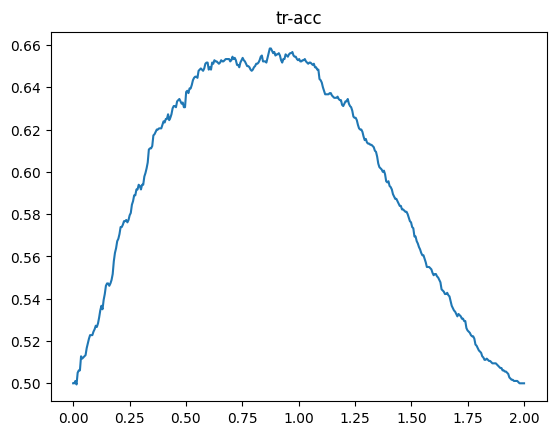

 Epoch [0] Max accuracy: 0.6583333333333333  |  Threshold:  0.8721804511278195


100%|██████████| 4/4 [00:18<00:00,  4.63s/it]


Loss on train 1 epoch is 0.0148681640625


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


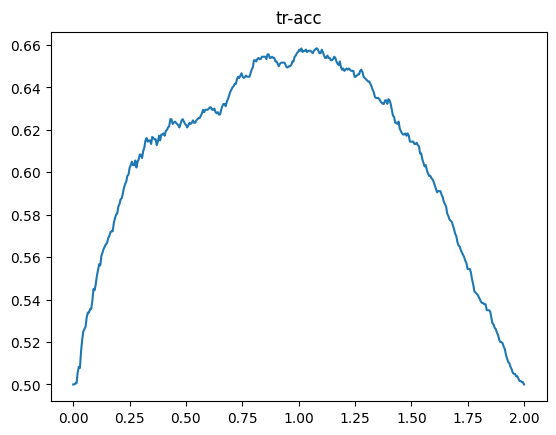

 Epoch [1] Max accuracy: 0.6583333333333333  |  Threshold:  1.012531328320802


100%|██████████| 4/4 [00:18<00:00,  4.72s/it]


Loss on train 2 epoch is 0.01639404296875


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


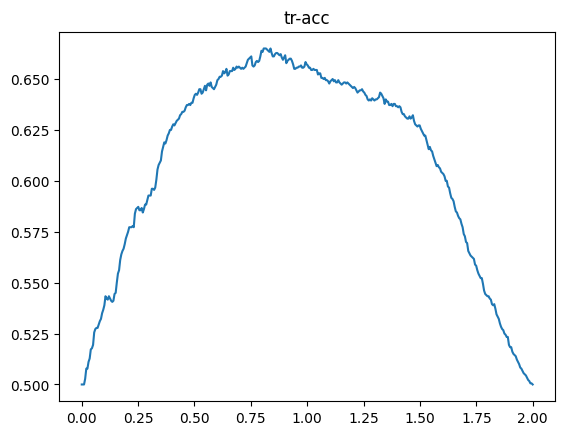

 Epoch [2] Max accuracy: 0.665  |  Threshold:  0.8070175438596491


100%|██████████| 4/4 [00:18<00:00,  4.71s/it]


Loss on train 3 epoch is 0.014111328125


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


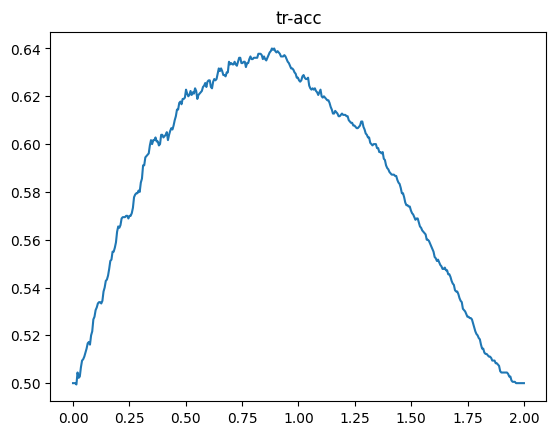

 Epoch [3] Max accuracy: 0.64  |  Threshold:  0.8822055137844611


100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


Loss on train 4 epoch is 0.01483154296875


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


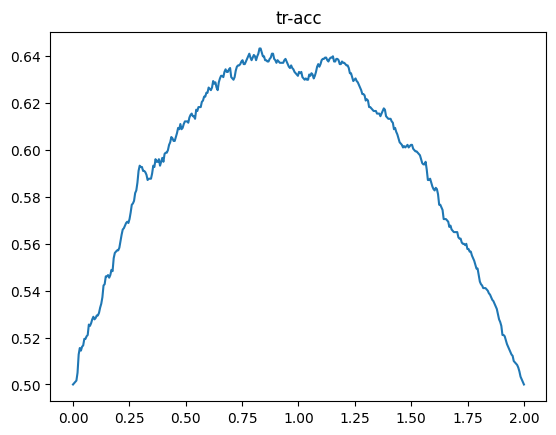

 Epoch [4] Max accuracy: 0.6433333333333333  |  Threshold:  0.8270676691729323


100%|██████████| 4/4 [00:18<00:00,  4.74s/it]


Loss on train 5 epoch is 0.01270751953125


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


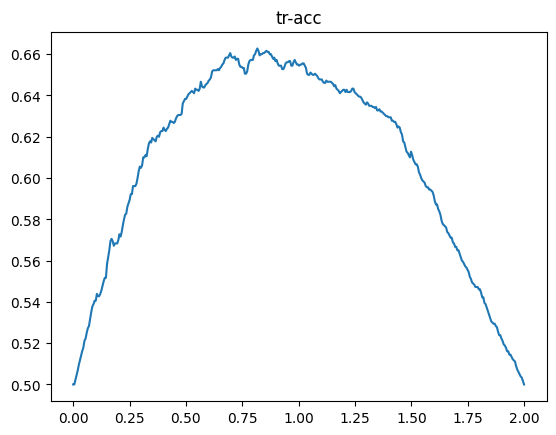

 Epoch [5] Max accuracy: 0.6627777777777778  |  Threshold:  0.8170426065162907


100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


Loss on train 6 epoch is 0.0144775390625


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


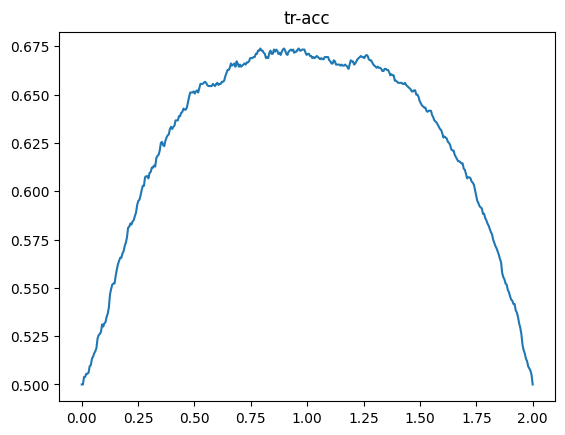

 Epoch [6] Max accuracy: 0.6738888888888889  |  Threshold:  0.7919799498746867


100%|██████████| 4/4 [00:19<00:00,  4.76s/it]


Loss on train 7 epoch is 0.014013671875


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


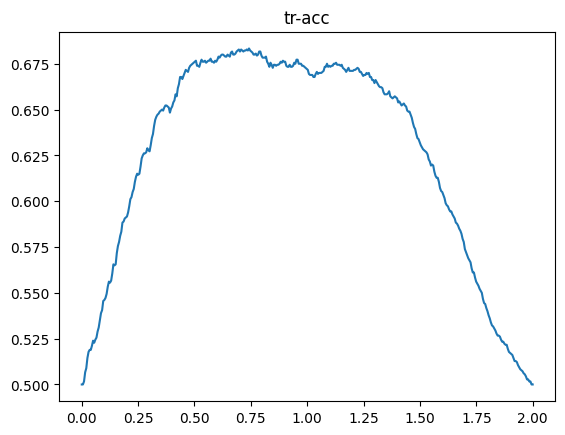

 Epoch [7] Max accuracy: 0.6833333333333333  |  Threshold:  0.7418546365914787


100%|██████████| 4/4 [00:18<00:00,  4.75s/it]


Loss on train 8 epoch is 0.01324462890625


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


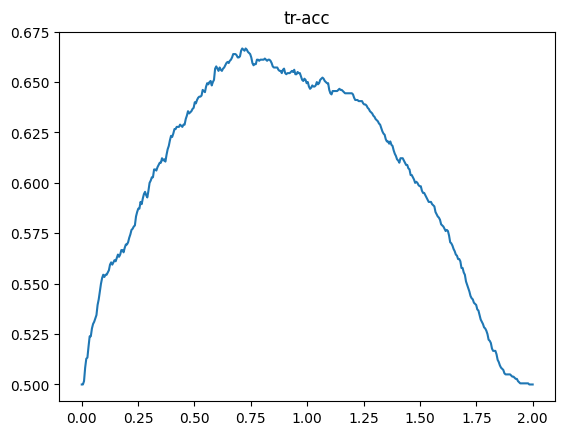

 Epoch [8] Max accuracy: 0.6666666666666666  |  Threshold:  0.7117794486215538


100%|██████████| 4/4 [00:18<00:00,  4.74s/it]


Loss on train 9 epoch is 0.0129150390625


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


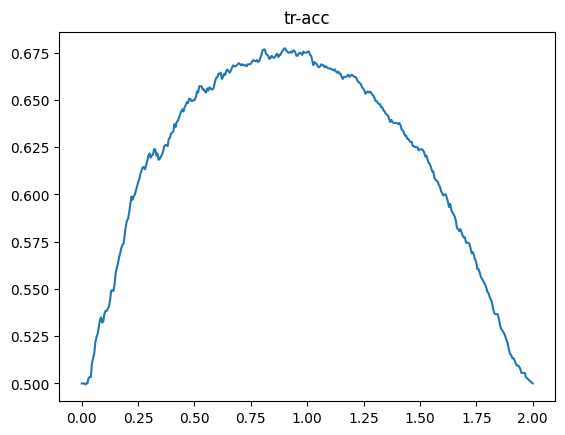

 Epoch [9] Max accuracy: 0.6772222222222222  |  Threshold:  0.8972431077694235


In [45]:
train_face_net(model, loss, train_loader, val_loader, optimizer, epoch=10, mode="semi-hard", n=5, margin=4)

In [47]:
torch.save(model.state_dict(), "model_0.67_224x224_128")